In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

2024-12-04 22:54:12.004791: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
file_path = "ibm.csv"
file_cleaned_path = "cleaned_ibm.csv"
data = pd.read_csv(file_path)

print(data.head())

                        Date      Open      High       Low     Close  Volume  \
0  1962-01-02 00:00:00-05:00  1.518550  1.518550  1.501487  1.501487  407940   
1  1962-01-03 00:00:00-05:00  1.501487  1.514612  1.501487  1.514612  305955   
2  1962-01-04 00:00:00-05:00  1.514613  1.514613  1.498863  1.499519  274575   
3  1962-01-05 00:00:00-05:00  1.497551  1.497551  1.467363  1.469988  384405   
4  1962-01-08 00:00:00-05:00  1.468675  1.468675  1.430613  1.442425  572685   

   Dividends  Stock Splits  
0        0.0           0.0  
1        0.0           0.0  
2        0.0           0.0  
3        0.0           0.0  
4        0.0           0.0  


In [3]:
data_filtered = data[["Date", "Open", "High", "Low", "Volume", "Close"]].sort_values(by="Date")
data_cleaned = data_filtered.dropna()
print(data_filtered.head())

                        Date      Open      High       Low  Volume     Close
0  1962-01-02 00:00:00-05:00  1.518550  1.518550  1.501487  407940  1.501487
1  1962-01-03 00:00:00-05:00  1.501487  1.514612  1.501487  305955  1.514612
2  1962-01-04 00:00:00-05:00  1.514613  1.514613  1.498863  274575  1.499519
3  1962-01-05 00:00:00-05:00  1.497551  1.497551  1.467363  384405  1.469988
4  1962-01-08 00:00:00-05:00  1.468675  1.468675  1.430613  572685  1.442425


In [4]:
data_cleaned.to_csv(file_cleaned_path, index=False)

In [5]:
data = pd.read_csv(file_cleaned_path)

In [6]:
data["Target"] = data["Close"].shift(-1)
data.head()

,Date,Open,High,Low,Volume,Close,Target
0,1962-01-02 00:00:00-05:00,1.518550,1.518550,1.501487,407940,1.501487,1.514612
1,1962-01-03 00:00:00-05:00,1.501487,1.514612,1.501487,305955,1.514612,1.499519
2,1962-01-04 00:00:00-05:00,1.514613,1.514613,1.498863,274575,1.499519,1.469988
3,1962-01-05 00:00:00-05:00,1.497551,1.497551,1.467363,384405,1.469988,1.442425
4,1962-01-08 00:00:00-05:00,1.468675,1.468675,1.430613,572685,1.442425,1.459488


In [7]:
final_data_row = data.tail(1)
data.drop(data.tail(1).index, inplace=True)
data.dropna(inplace=True)
final_data_row

,Date,Open,High,Low,Volume,Close,Target
15825,2024-11-13 00:00:00-05:00,209.5,211.410004,209.070099,2186158,210.669998,NaN


In [8]:
# plotting correlation
data.iloc[:, 1:].corr()['Target']

Open      0.999714
High      0.999765
Low       0.999767
Volume    0.133558
Close     0.999812
Target    1.000000
Name: Target, dtype: float64

In [9]:
# Features scaling
model_features = data.drop("Target", axis=1).drop("Date", axis=1)
model_target = data["Target"]

model_feature_scaler = MinMaxScaler()
model_feature_scaler.fit(model_features)
model_scaled_features = pd.DataFrame(model_feature_scaler.transform(model_features), columns=model_features.columns.tolist())

model_target_scaler = MinMaxScaler()
model_target_scaler.fit(model_target.values.reshape(-1,1))
model_scaled_target = pd.DataFrame(model_target_scaler.transform(model_target.values.reshape(-1,1)), columns=["Target"])

In [10]:
def create_dataset(X_data, y_data, t_steps):
    X, y = [], []
    for i in range(len(X_data) - t_steps):
        v = X_data.iloc[i:(i + t_steps)].values
        X.append(v)
        y.append(y_data.iloc[i + t_steps])
    return np.array(X), np.array(y)

In [11]:
t_steps = 60
X, y = create_dataset(model_scaled_features, model_scaled_target, t_steps)
X.shape, y.shape

((15765, 60, 5), (15765, 1))

In [12]:
train_size = int(0.80 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape
# ((12612, 60, 5), (3153, 60, 5), (12612, 1), (3153, 1))

((12612, 60, 5), (3153, 60, 5), (12612, 1), (3153, 1))

In [13]:
X_train.shape

(12612, 60, 5)

In [14]:
import tensorflow as tf

X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

2024-12-04 22:54:24.015359: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2027] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 8.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
2024-12-04 22:54:24.023686: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2027] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 8.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
2024-12-04 22:54:25.085189: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22278 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:17:00.0, compute capability: 8.0


(TensorShape([12612, 60, 5]),
 TensorShape([12612, 1]),
 TensorShape([3153, 60, 5]),
 TensorShape([3153, 1]))

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [16]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_step, features)
input_shape

(60, 5)

In [17]:

from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


model = Sequential([
    # First LSTM layer with regularization
    LSTM(50, return_sequences=True,
            kernel_regularizer=l2(0.01),
            recurrent_regularizer=l2(0.01),
            input_shape=input_shape),
    Dropout(0.2),

    # Second LSTM layer
    LSTM(50, return_sequences=False,
            kernel_regularizer=l2(0.01),
            recurrent_regularizer=l2(0.01)),
    Dropout(0.2),

    # Output layer
    Dense(1)
])

In [18]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [19]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Reduce learning rate when plateau is reached
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-5
)

In [20]:
num_epochs = 30
batch_size = 64

history_lstm_before_optimization = model.fit(
        X_train, y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

Epoch 1/30


2024-12-04 22:54:31.783361: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2024-12-04 22:54:31.905973: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-12-04 22:54:31.906360: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fee34110b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-04 22:54:31.906375: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A30, Compute Capability 8.0
2024-12-04 22:54:31.910685: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-04 22:54:32.035808: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


198/198 [==============================] - 6s 10ms/step - loss: 0.4339 - val_loss: 0.0239 - lr: 0.0010
Epoch 2/30
198/198 [==============================] - 1s 6ms/step - loss: 0.0061 - val_loss: 0.0061 - lr: 0.0010
Epoch 3/30
198/198 [==============================] - 1s 6ms/step - loss: 0.0015 - val_loss: 0.0046 - lr: 0.0010
Epoch 4/30
198/198 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0068 - lr: 0.0010
Epoch 5/30
198/198 [==============================] - 1s 6ms/step - loss: 9.5072e-04 - val_loss: 0.0067 - lr: 0.0010
Epoch 6/30
198/198 [==============================] - 1s 6ms/step - loss: 8.7005e-04 - val_loss: 0.0069 - lr: 0.0010
Epoch 7/30
198/198 [==============================] - 1s 6ms/step - loss: 7.4937e-04 - val_loss: 0.0124 - lr: 0.0010
Epoch 8/30
198/198 [==============================] - 1s 6ms/step - loss: 7.4057e-04 - val_loss: 0.0022 - lr: 0.0010
Epoch 9/30
198/198 [==============================] - 1s 6ms/step - loss: 6.5517e-04 - val

In [35]:
# Evaluate on test data
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

99/99 [==============================] - 0s 3ms/step - loss: 0.0022
Test Loss: 0.00219588540494442


In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, rmse, mae


In [37]:
# Making predictions on the test set
# lstm_predictions = model.predict(X_test)
from sklearn.preprocessing import MinMaxScaler


predictions = model.predict(X_test)

# Adding dummy columns to match the original scaled data shape (5 columns)
# 4 dummy columns to match Open, High, Low, Volume
dummy_columns = np.zeros((predictions.shape[0], 4))
predicted_prices_scaled = np.concatenate((dummy_columns, predictions), axis=1)

# Applying inverse transformation to get back to original scale
predicted_prices = model_feature_scaler.inverse_transform(predicted_prices_scaled)[:, -1]

# for actual prices
actual_prices_scaled = np.concatenate((dummy_columns, y_test.numpy().reshape(-1, 1)), axis=1)
actual_prices = model_feature_scaler.inverse_transform(actual_prices_scaled)[:, -1]

# Calculating metrics
lstm_mse, lstm_rmse, lstm_mae = calculate_metrics(actual_prices, predicted_prices)
print(f'LSTM Model - MSE: {lstm_mse:.4f}, RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}')

99/99 [==============================] - 1s 2ms/step
LSTM Model - MSE: 102.2077, RMSE: 10.1098, MAE: 6.1998


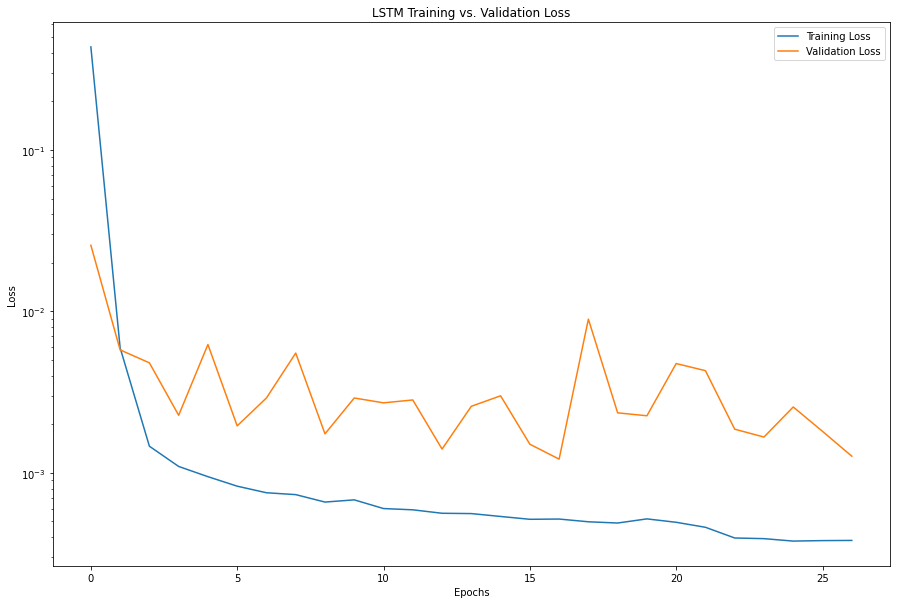

In [30]:
# Your existing plotting code with log scale
import matplotlib.pyplot as plt

%matplotlib inline
plt.figure(figsize=(15, 10))
plt.plot(history_lstm_before_optimization.history['loss'], label='Training Loss')
plt.plot(history_lstm_before_optimization.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.yscale('log')  # Setting the y-axis to logarithmic scale


plt.legend()
plt.show()


### Training the model with hyperparameters obtained from random search
Best Hyperparameters: LSTM Units = 245, Batch Size = 56, Time Steps = 30, Early Stopping Patience = 13, Reduce LR Factor = 0.12, Reduce LR Patience = 6, Min LR = 0.000083

In [31]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

t_steps = 30
X, y = create_dataset(model_scaled_features, model_scaled_target, t_steps)

train_size = int(0.80 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

#converting into tensor
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

input_shape = (X_train.shape[1], X_train.shape[2])

#batch size and no of epochs
num_epochs = 30
batch_size = 56

model_optimized = Sequential([
    # First LSTM layer with regularization
    LSTM(245, return_sequences=True,
            kernel_regularizer=l2(0.01),
            recurrent_regularizer=l2(0.01),
            input_shape=input_shape),
    Dropout(0.2),

    # Second LSTM layer
    LSTM(245, return_sequences=False,
            kernel_regularizer=l2(0.01),
            recurrent_regularizer=l2(0.01)),
    Dropout(0.2),

    # Output layer
    Dense(1)
])

model_optimized.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=13,
    restore_best_weights=True
)

# Reduce learning rate when plateau is reached
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.12,
    patience=6,
    min_lr=0.000083
)

history_lstm_after_optimization = model_optimized.fit(
        X_train, y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

Epoch 1/30
226/226 [==============================] - 6s 9ms/step - loss: 0.7724 - val_loss: 0.0036 - lr: 0.0010
Epoch 2/30
226/226 [==============================] - 1s 6ms/step - loss: 0.0015 - val_loss: 0.0022 - lr: 0.0010
Epoch 3/30
226/226 [==============================] - 1s 6ms/step - loss: 9.9350e-04 - val_loss: 0.0035 - lr: 0.0010
Epoch 4/30
226/226 [==============================] - 1s 6ms/step - loss: 7.9099e-04 - val_loss: 0.0018 - lr: 0.0010
Epoch 5/30
226/226 [==============================] - 1s 6ms/step - loss: 7.2888e-04 - val_loss: 0.0036 - lr: 0.0010
Epoch 6/30
226/226 [==============================] - 1s 6ms/step - loss: 7.2058e-04 - val_loss: 0.0018 - lr: 0.0010
Epoch 7/30
226/226 [==============================] - 1s 6ms/step - loss: 5.8426e-04 - val_loss: 0.0019 - lr: 0.0010
Epoch 8/30
226/226 [==============================] - 1s 6ms/step - loss: 6.0239e-04 - val_loss: 0.0026 - lr: 0.0010
Epoch 9/30
226/226 [==============================] - 1s 6ms/step - loss

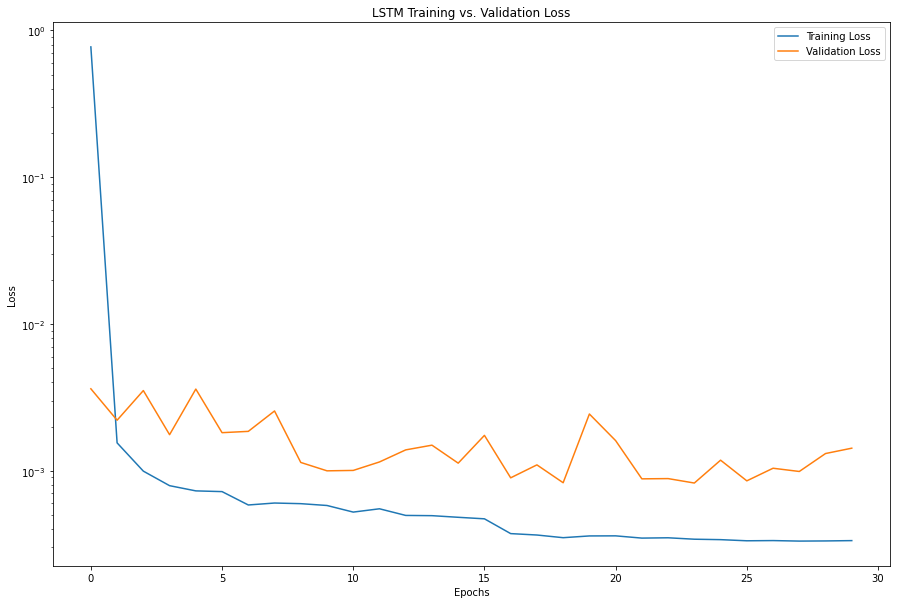

In [32]:
# Your existing plotting code with log scale

plt.figure(figsize=(15, 10))
plt.plot(history_lstm_after_optimization.history['loss'], label='Training Loss')
plt.plot(history_lstm_after_optimization.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.yscale('log')  # Setting the y-axis to logarithmic scale


plt.legend()
plt.show()

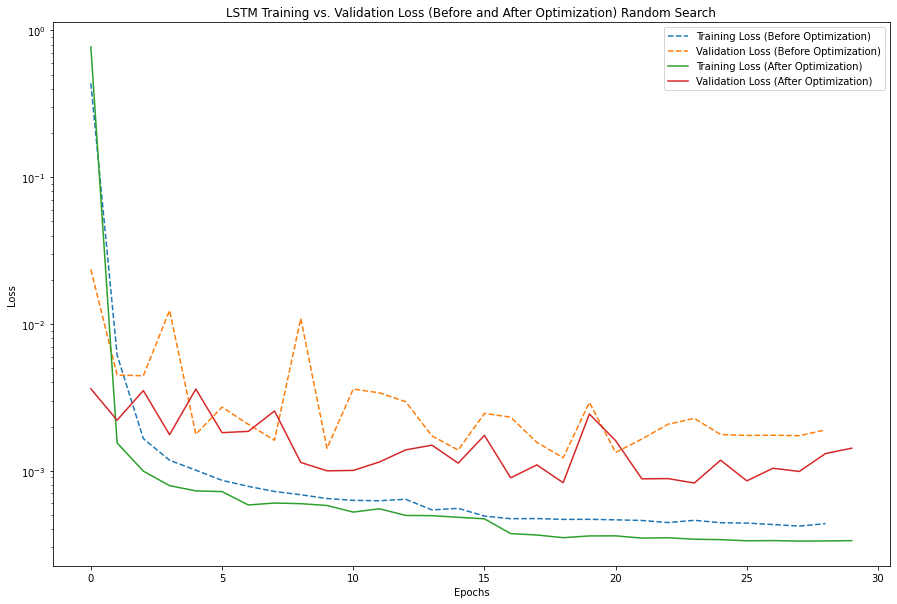

In [54]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(15, 10))

# Plotting loss before optimization
plt.plot(history_lstm_before_optimization.history['loss'], label='Training Loss (Before Optimization)', linestyle='--')
plt.plot(history_lstm_before_optimization.history['val_loss'], label='Validation Loss (Before Optimization)', linestyle='--')

# Plotting loss after optimization
plt.plot(history_lstm_after_optimization.history['loss'], label='Training Loss (After Optimization)')
plt.plot(history_lstm_after_optimization.history['val_loss'], label='Validation Loss (After Optimization)')

plt.title('LSTM Training vs. Validation Loss (Before and After Optimization) Random Search')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Setting the y-axis to logarithmic scale
plt.yscale('log')

plt.legend()
plt.show()


In [34]:
plt.savefig('lstm_loss_comparison_random_search.png', dpi=300, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

## For pso

Best Hyperparameters: LSTM Units = 242, Batch Size = 43, Time Steps = 84, Early Stopping Patience = 17, Reduce LR Factor = 0.26, Reduce LR Patience = 8, Min LR = 0.000020

In [51]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

t_steps = 84
X, y = create_dataset(model_scaled_features, model_scaled_target, t_steps)

train_size = int(0.80 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

#converting into tensor
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

input_shape = (X_train.shape[1], X_train.shape[2])

#batch size and no of epochs
num_epochs = 30
batch_size = 43

model_optimized = Sequential([
    # First LSTM layer with regularization
    LSTM(242, return_sequences=True,
            kernel_regularizer=l2(0.01),
            recurrent_regularizer=l2(0.01),
            input_shape=input_shape),
    Dropout(0.2),

    # Second LSTM layer
    LSTM(242, return_sequences=False,
            kernel_regularizer=l2(0.01),
            recurrent_regularizer=l2(0.01)),
    Dropout(0.2),

    # Output layer
    Dense(1)
])

model_optimized.compile(optimizer=Adam(learning_rate=0.001090), loss='mean_squared_error')

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=17,
    restore_best_weights=True
)

# Reduce learning rate when plateau is reached
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.26,
    patience=8,
    min_lr=0.000020
)

history_lstm_after_optimization_pso = model_optimized.fit(
        X_train, y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

Epoch 1/30
293/293 [==============================] - 8s 13ms/step - loss: 0.5454 - val_loss: 0.0030 - lr: 0.0011
Epoch 2/30
293/293 [==============================] - 3s 11ms/step - loss: 0.0013 - val_loss: 0.0036 - lr: 0.0011
Epoch 3/30
293/293 [==============================] - 3s 11ms/step - loss: 9.0592e-04 - val_loss: 0.0049 - lr: 0.0011
Epoch 4/30
293/293 [==============================] - 3s 11ms/step - loss: 7.8620e-04 - val_loss: 0.0012 - lr: 0.0011
Epoch 5/30
293/293 [==============================] - 3s 11ms/step - loss: 7.3539e-04 - val_loss: 0.0049 - lr: 0.0011
Epoch 6/30
293/293 [==============================] - 3s 11ms/step - loss: 6.5463e-04 - val_loss: 0.0020 - lr: 0.0011
Epoch 7/30
293/293 [==============================] - 3s 11ms/step - loss: 6.7829e-04 - val_loss: 0.0070 - lr: 0.0011
Epoch 8/30
293/293 [==============================] - 3s 11ms/step - loss: 6.4546e-04 - val_loss: 0.0044 - lr: 0.0011
Epoch 9/30
293/293 [==============================] - 3s 11ms/st

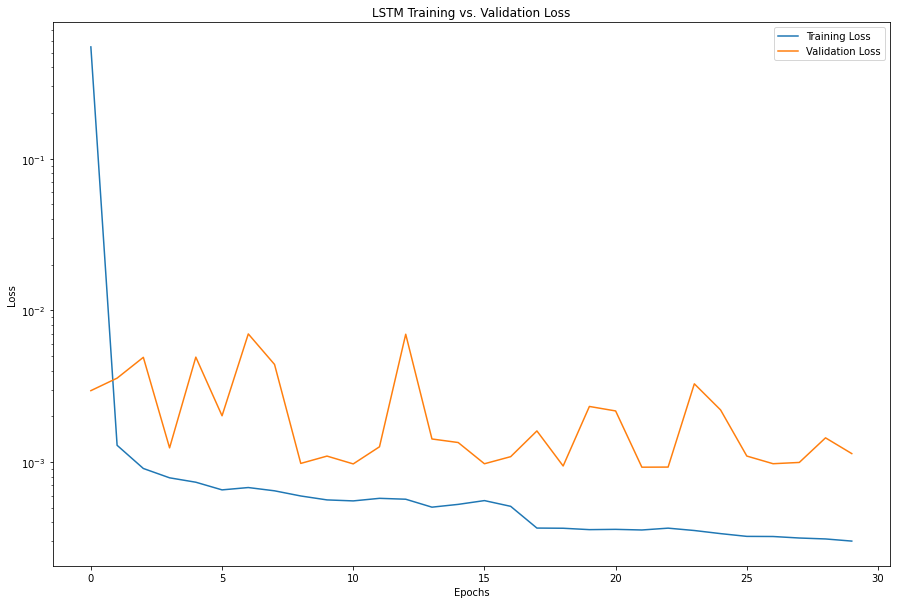

In [52]:

plt.figure(figsize=(15, 10))
plt.plot(history_lstm_after_optimization_pso.history['loss'], label='Training Loss')
plt.plot(history_lstm_after_optimization_pso.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.yscale('log')  # Setting the y-axis to logarithmic scale


plt.legend()
plt.show()

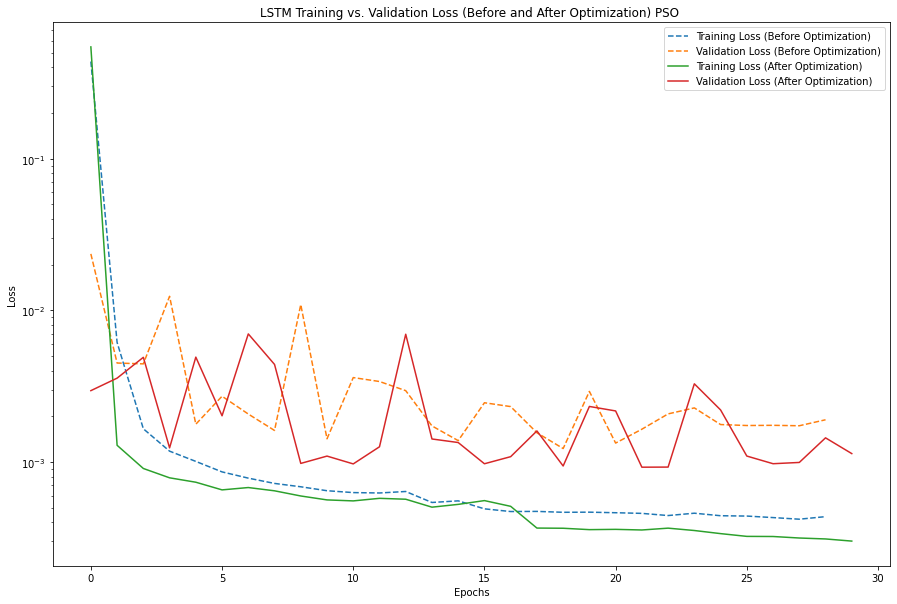

In [53]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(15, 10))

# Plotting loss before optimization
plt.plot(history_lstm_before_optimization.history['loss'], label='Training Loss (Before Optimization)', linestyle='--')
plt.plot(history_lstm_before_optimization.history['val_loss'], label='Validation Loss (Before Optimization)', linestyle='--')

# Plotting loss after optimization
plt.plot(history_lstm_after_optimization_pso.history['loss'], label='Training Loss (After Optimization)')
plt.plot(history_lstm_after_optimization_pso.history['val_loss'], label='Validation Loss (After Optimization)')

plt.title('LSTM Training vs. Validation Loss (Before and After Optimization) PSO ')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Setting the y-axis to logarithmic scale
plt.yscale('log')

plt.legend()
plt.show()


## GA

Best Hyperparameters: {'lstm_units': 222, 'batch_size': 47, 'time_steps': 108, 'early_stopping_patience': 20, 'reduce_lr_factor': 0.4142027272179486, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 1.3492242355288493e-06}
Best Validation Loss: 0.001012942404486239

In [55]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

t_steps = 108
X, y = create_dataset(model_scaled_features, model_scaled_target, t_steps)

train_size = int(0.80 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# converting into tensor
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

input_shape = (X_train.shape[1], X_train.shape[2])

#batch size and no of epochs
num_epochs = 30
batch_size = 47

model_optimized = Sequential([
    # First LSTM layer with regularization
    LSTM(222, return_sequences=True,
            kernel_regularizer=l2(0.01),
            recurrent_regularizer=l2(0.01),
            input_shape=input_shape),
    Dropout(0.2),

    # Second LSTM layer
    LSTM(222, return_sequences=False,
            kernel_regularizer=l2(0.01),
            recurrent_regularizer=l2(0.01)),
    Dropout(0.2),

    # Output layer
    Dense(1)
])

model_optimized.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# Reducing learning rate when plateau is reached
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.4142027272179486,
    patience=7,
    min_lr=1.3492242355288493e-06
)

history_lstm_after_optimization_ga = model_optimized.fit(
        X_train, y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

Epoch 1/30
268/268 [==============================] - 7s 15ms/step - loss: 0.6241 - val_loss: 0.0027 - lr: 0.0010
Epoch 2/30
268/268 [==============================] - 3s 12ms/step - loss: 0.0014 - val_loss: 0.0044 - lr: 0.0010
Epoch 3/30
268/268 [==============================] - 3s 12ms/step - loss: 9.3654e-04 - val_loss: 0.0021 - lr: 0.0010
Epoch 4/30
268/268 [==============================] - 3s 12ms/step - loss: 7.8218e-04 - val_loss: 0.0029 - lr: 0.0010
Epoch 5/30
268/268 [==============================] - 3s 12ms/step - loss: 7.3879e-04 - val_loss: 0.0026 - lr: 0.0010
Epoch 6/30
268/268 [==============================] - 3s 12ms/step - loss: 6.5986e-04 - val_loss: 0.0032 - lr: 0.0010
Epoch 7/30
268/268 [==============================] - 3s 12ms/step - loss: 6.2285e-04 - val_loss: 0.0015 - lr: 0.0010
Epoch 8/30
268/268 [==============================] - 3s 12ms/step - loss: 6.1316e-04 - val_loss: 0.0010 - lr: 0.0010
Epoch 9/30
268/268 [==============================] - 3s 12ms/st

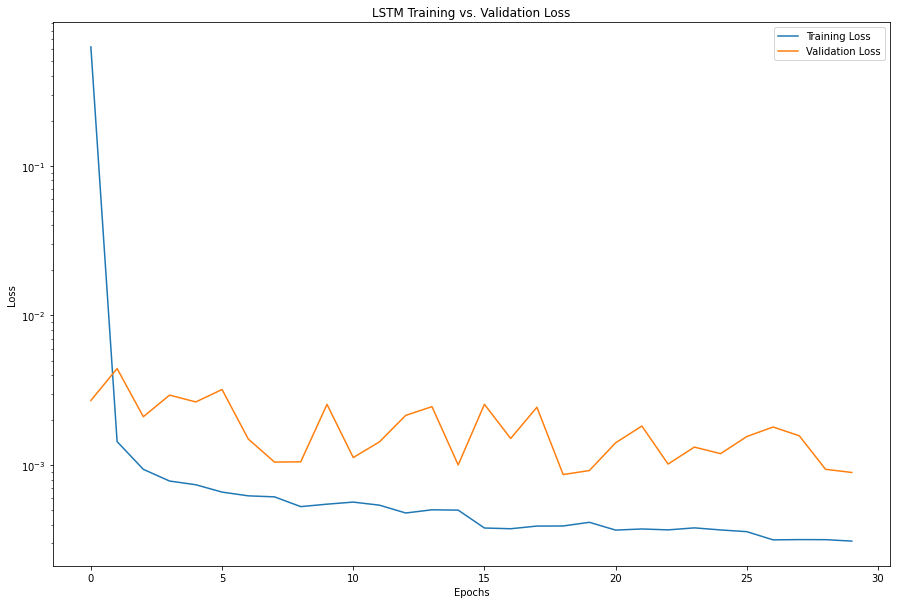

In [56]:
plt.figure(figsize=(15, 10))
plt.plot(history_lstm_after_optimization_ga.history['loss'], label='Training Loss')
plt.plot(history_lstm_after_optimization_ga.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.yscale('log')  # Setting the y-axis to logarithmic scale


plt.legend()
plt.show()

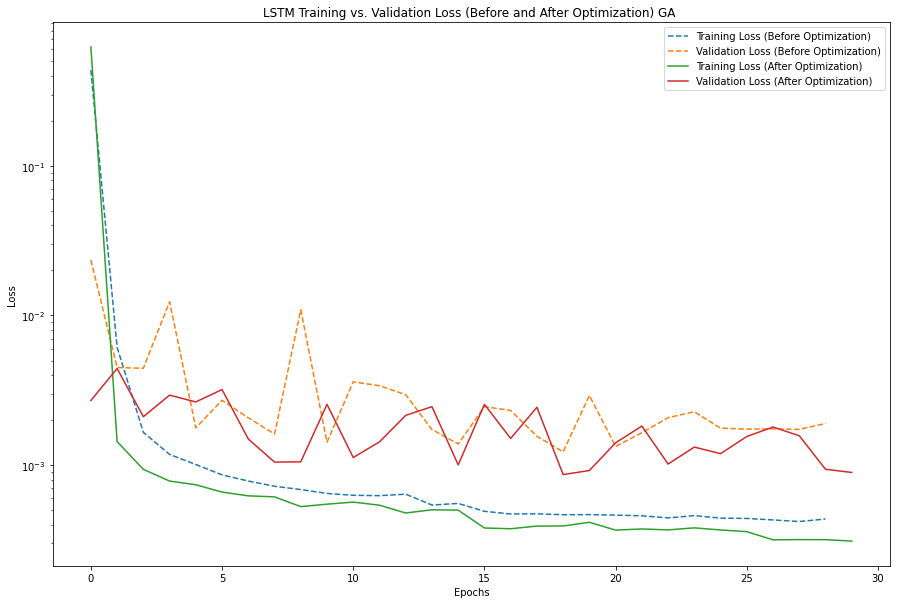

In [57]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(15, 10))

# Plotting loss before optimization
plt.plot(history_lstm_before_optimization.history['loss'], label='Training Loss (Before Optimization)', linestyle='--')
plt.plot(history_lstm_before_optimization.history['val_loss'], label='Validation Loss (Before Optimization)', linestyle='--')

# Plotting loss after optimization
plt.plot(history_lstm_after_optimization_ga.history['loss'], label='Training Loss (After Optimization)')
plt.plot(history_lstm_after_optimization_ga.history['val_loss'], label='Validation Loss (After Optimization)')

plt.title('LSTM Training vs. Validation Loss (Before and After Optimization) GA ')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Setting the y-axis to logarithmic scale
plt.yscale('log')

plt.legend()
plt.show()

## GA 

for population size = 9,number of generation = 6, number of parents = 5

Best Hyperparameters: {'lstm_units': 162, 'batch_size': 22, 'time_steps': 89, 'early_stopping_patience': 12, 'reduce_lr_factor': 0.34237326001872903, 'reduce_lr_patience': 5, 'reduce_lr_min_lr': 4.838814734911748e-05}
Best Validation Loss: 0.0010246431920677423

In [39]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

t_steps = 89
X, y = create_dataset(model_scaled_features, model_scaled_target, t_steps)

train_size = int(0.80 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# converting into tensor
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

input_shape = (X_train.shape[1], X_train.shape[2])

#batch size and no of epochs
num_epochs = 30
batch_size = 22

model_optimized = Sequential([
    # First LSTM layer with regularization
    LSTM(222, return_sequences=True,
            kernel_regularizer=l2(0.01),
            recurrent_regularizer=l2(0.01),
            input_shape=input_shape),
    Dropout(0.2),

    # Second LSTM layer
    LSTM(222, return_sequences=False,
            kernel_regularizer=l2(0.01),
            recurrent_regularizer=l2(0.01)),
    Dropout(0.2),

    # Output layer
    Dense(1)
])

model_optimized.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=12,
    restore_best_weights=True
)

# Reducing learning rate when plateau is reached
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.34237326001872903,
    patience=5,
    min_lr=4.838814734911748e-05
)

history_lstm_after_optimization_ga1 = model_optimized.fit(
        X_train, y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

Epoch 1/30
573/573 [==============================] - 12s 14ms/step - loss: 0.2922 - val_loss: 0.0037 - lr: 0.0010
Epoch 2/30
573/573 [==============================] - 7s 12ms/step - loss: 0.0011 - val_loss: 0.0015 - lr: 0.0010
Epoch 3/30
573/573 [==============================] - 7s 12ms/step - loss: 8.8069e-04 - val_loss: 0.0033 - lr: 0.0010
Epoch 4/30
573/573 [==============================] - 7s 12ms/step - loss: 7.5522e-04 - val_loss: 0.0042 - lr: 0.0010
Epoch 5/30
573/573 [==============================] - 7s 12ms/step - loss: 7.4325e-04 - val_loss: 0.0019 - lr: 0.0010
Epoch 6/30
573/573 [==============================] - 7s 12ms/step - loss: 6.7143e-04 - val_loss: 0.0020 - lr: 0.0010
Epoch 7/30
573/573 [==============================] - 7s 12ms/step - loss: 6.2889e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 8/30
573/573 [==============================] - 7s 12ms/step - loss: 5.9512e-04 - val_loss: 0.0018 - lr: 0.0010
Epoch 9/30
573/573 [==============================] - 7s 12ms/s

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, rmse, mae

In [41]:
# Making predictions on the test set
# lstm_predictions = model.predict(X_test)
from sklearn.preprocessing import MinMaxScaler


predictions = model_optimized.predict(X_test)

# Adding dummy columns to match the original scaled data shape (5 columns)
# 4 dummy columns to match Open, High, Low, Volume
dummy_columns = np.zeros((predictions.shape[0], 4))
predicted_prices_scaled = np.concatenate((dummy_columns, predictions), axis=1)

# Applying inverse transformation to get back to original scale
predicted_prices = model_feature_scaler.inverse_transform(predicted_prices_scaled)[:, -1]

# for actual prices
actual_prices_scaled = np.concatenate((dummy_columns, y_test.numpy().reshape(-1, 1)), axis=1)
actual_prices = model_feature_scaler.inverse_transform(actual_prices_scaled)[:, -1]

# Calculating metrics
lstm_mse, lstm_rmse, lstm_mae = calculate_metrics(actual_prices, predicted_prices)
print(f'LSTM Model GA(8,4,4) - MSE: {lstm_mse:.4f}, RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}')

99/99 [==============================] - 2s 5ms/step
LSTM Model GA(8,4,4) - MSE: 46.0090, RMSE: 6.7830, MAE: 5.0788


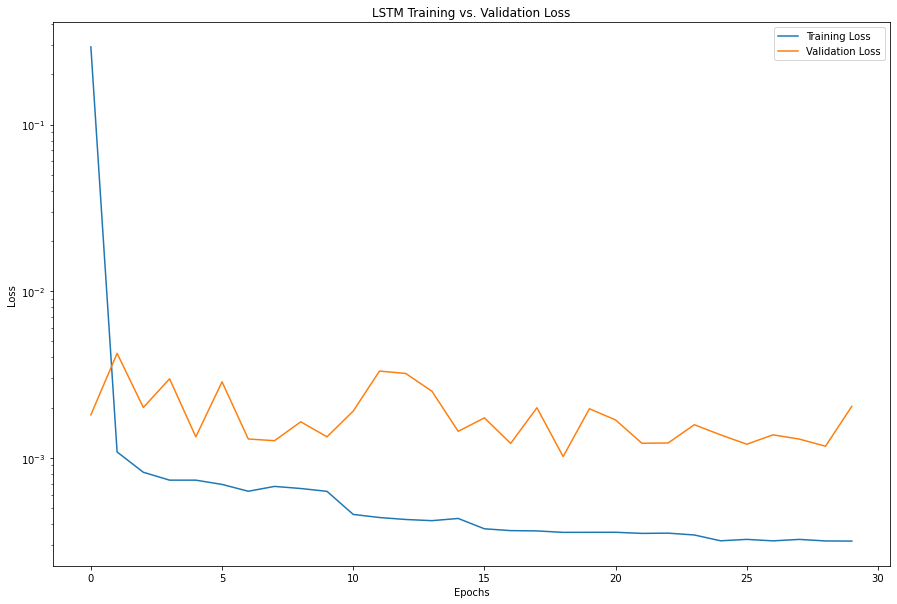

In [15]:
%matplotlib inline

plt.figure(figsize=(15, 10))
plt.plot(history_lstm_after_optimization_ga1.history['loss'], label='Training Loss')
plt.plot(history_lstm_after_optimization_ga1.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.yscale('log')  # Setting the y-axis to logarithmic scale


plt.legend()
plt.show()

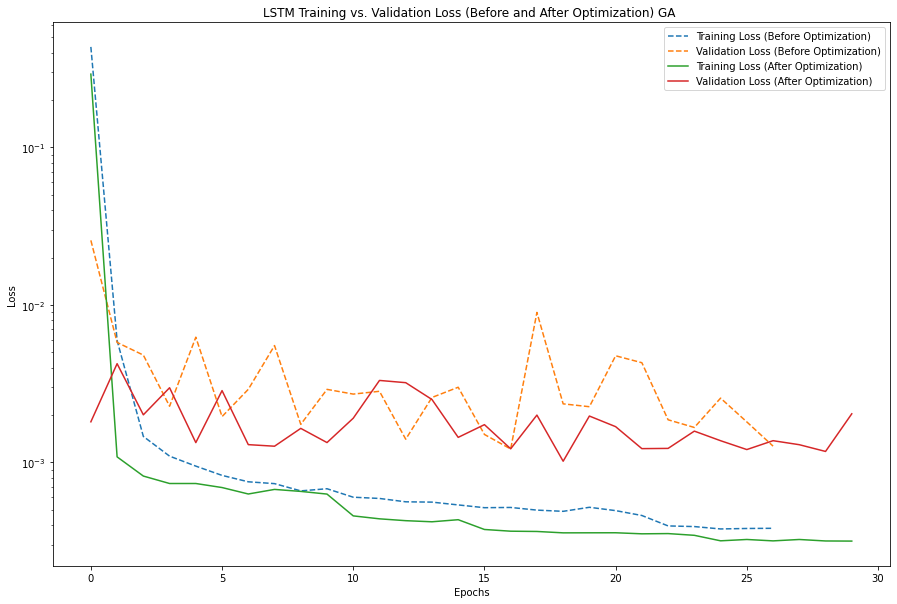

In [31]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(15, 10))

# Plotting loss before optimization
plt.plot(history_lstm_before_optimization.history['loss'], label='Training Loss (Before Optimization)', linestyle='--')
plt.plot(history_lstm_before_optimization.history['val_loss'], label='Validation Loss (Before Optimization)', linestyle='--')

# Plotting loss after optimization
plt.plot(history_lstm_after_optimization_ga1.history['loss'], label='Training Loss (After Optimization)')
plt.plot(history_lstm_after_optimization_ga1.history['val_loss'], label='Validation Loss (After Optimization)')

plt.title('LSTM Training vs. Validation Loss (Before and After Optimization) GA ')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Setting the y-axis to logarithmic scale
plt.yscale('log')

plt.legend()
plt.show()

### GA
pop size = 8, gen = 4, parent = 4

Best Hyperparameters: {'lstm_units': 208, 'batch_size': 31, 'time_steps': 43, 'early_stopping_patience': 6, 'reduce_lr_factor': 0.2591562335424562, 'reduce_lr_patience': 9, 'reduce_lr_min_lr': 6.630258506044344e-05}
Best Validation Loss: 0.0009929481893777847

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

t_steps = 43
X, y = create_dataset(model_scaled_features, model_scaled_target, t_steps)

train_size = int(0.80 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# converting into tensor
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

input_shape = (X_train.shape[1], X_train.shape[2])

#batch size and no of epochs
num_epochs = 30
batch_size = 31

model_optimized = Sequential([
    # First LSTM layer with regularization
    LSTM(208, return_sequences=True,
            kernel_regularizer=l2(0.01),
            recurrent_regularizer=l2(0.01),
            input_shape=input_shape),
    Dropout(0.2),

    # Second LSTM layer
    LSTM(208, return_sequences=False,
            kernel_regularizer=l2(0.01),
            recurrent_regularizer=l2(0.01)),
    Dropout(0.2),

    # Output layer
    Dense(1)
])

model_optimized.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

# Reducing learning rate when plateau is reached
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2591562335424562,
    patience=9,
    min_lr=6.630258506044344e-05
)

history_lstm_after_optimization_ga2 = model_optimized.fit(
        X_train, y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

2024-12-04 10:10:39.509506: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14782 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


Epoch 1/30


2024-12-04 10:10:45.227983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2024-12-04 10:10:45.420037: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f1928114160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-04 10:10:45.420075: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-PCIE-16GB, Compute Capability 7.0
2024-12-04 10:10:45.426415: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-04 10:10:45.587563: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


408/408 [==============================] - 10s 11ms/step - loss: 0.3982 - val_loss: 0.0045 - lr: 0.0010
Epoch 2/30
408/408 [==============================] - 4s 9ms/step - loss: 0.0012 - val_loss: 0.0025 - lr: 0.0010
Epoch 3/30
408/408 [==============================] - 4s 9ms/step - loss: 8.9835e-04 - val_loss: 0.0019 - lr: 0.0010
Epoch 4/30
408/408 [==============================] - 4s 9ms/step - loss: 7.4948e-04 - val_loss: 0.0027 - lr: 0.0010
Epoch 5/30
408/408 [==============================] - 4s 9ms/step - loss: 6.9254e-04 - val_loss: 0.0015 - lr: 0.0010
Epoch 6/30
408/408 [==============================] - 4s 9ms/step - loss: 7.3262e-04 - val_loss: 0.0015 - lr: 0.0010
Epoch 7/30
408/408 [==============================] - 4s 9ms/step - loss: 6.1502e-04 - val_loss: 0.0026 - lr: 0.0010
Epoch 8/30
408/408 [==============================] - 4s 9ms/step - loss: 5.7723e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 9/30
408/408 [==============================] - 4s 9ms/step - loss: 6.1472e

In [14]:
# Evaluate on test data
test_loss = model_optimized.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

99/99 [==============================] - 0s 4ms/step - loss: 9.6838e-04
Test Loss: 0.000968383566942066


In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, rmse, mae


In [16]:
# Making predictions on the test set
# lstm_predictions = model.predict(X_test)
from sklearn.preprocessing import MinMaxScaler


predictions = model_optimized.predict(X_test)

# Adding dummy columns to match the original scaled data shape (5 columns)
# 4 dummy columns to match Open, High, Low, Volume
dummy_columns = np.zeros((predictions.shape[0], 4))
predicted_prices_scaled = np.concatenate((dummy_columns, predictions), axis=1)

# Applying inverse transformation to get back to original scale
predicted_prices = model_feature_scaler.inverse_transform(predicted_prices_scaled)[:, -1]

# for actual prices
actual_prices_scaled = np.concatenate((dummy_columns, y_test.numpy().reshape(-1, 1)), axis=1)
actual_prices = model_feature_scaler.inverse_transform(actual_prices_scaled)[:, -1]

# Calculating metrics
lstm_mse, lstm_rmse, lstm_mae = calculate_metrics(actual_prices, predicted_prices)
print(f'LSTM Model GA(8,4,4) - MSE: {lstm_mse:.4f}, RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}')

99/99 [==============================] - 1s 4ms/step
LSTM Model GA(8,4,4) - MSE: 45.2074, RMSE: 6.7236, MAE: 4.5390


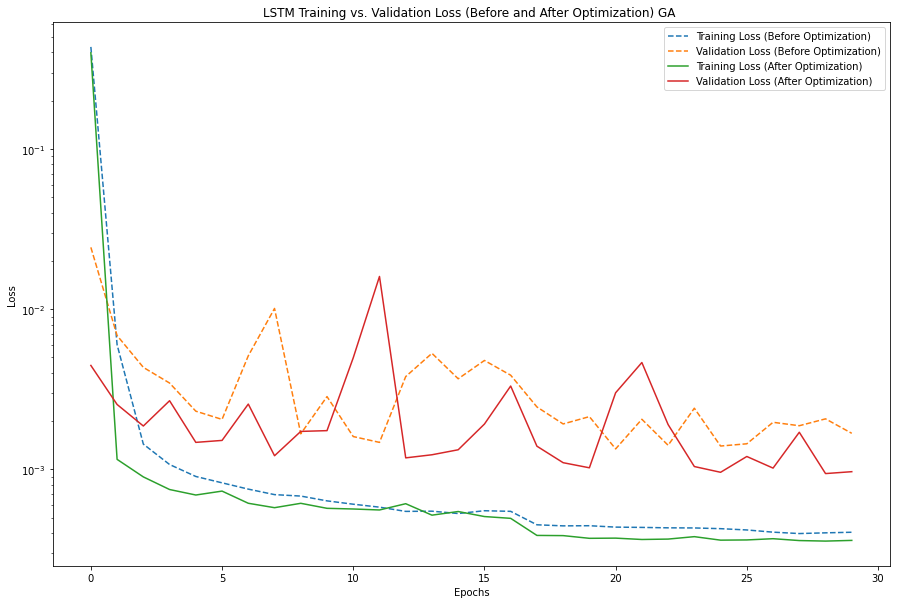

In [38]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(15, 10))

# Plotting loss before optimization
plt.plot(history_lstm_before_optimization.history['loss'], label='Training Loss (Before Optimization)', linestyle='--')
plt.plot(history_lstm_before_optimization.history['val_loss'], label='Validation Loss (Before Optimization)', linestyle='--')

# Plotting loss after optimization
plt.plot(history_lstm_after_optimization_ga2.history['loss'], label='Training Loss (After Optimization)')
plt.plot(history_lstm_after_optimization_ga2.history['val_loss'], label='Validation Loss (After Optimization)')

plt.title('LSTM Training vs. Validation Loss (Before and After Optimization) GA ')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Setting the y-axis to logarithmic scale
plt.yscale('log')

plt.legend()
plt.show()

### GA (7,3,3)

Best Hyperparameters: {'lstm_units': 249, 'batch_size': 40, 'time_steps': 85, 'early_stopping_patience': 16, 'reduce_lr_factor': 0.22593170808196217, 'reduce_lr_patience': 6, 'reduce_lr_min_lr': 5.533531200909064e-05}
Best Validation Loss: 0.0009669280843809247

In [43]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

t_steps = 85
X, y = create_dataset(model_scaled_features, model_scaled_target, t_steps)

train_size = int(0.80 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# converting into tensor
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

input_shape = (X_train.shape[1], X_train.shape[2])

#batch size and no of epochs
num_epochs = 30
batch_size = 40

model_optimized = Sequential([
    # First LSTM layer with regularization
    LSTM(249, return_sequences=True,
            kernel_regularizer=l2(0.01),
            recurrent_regularizer=l2(0.01),
            input_shape=input_shape),
    Dropout(0.2),

    # Second LSTM layer
    LSTM(249, return_sequences=False,
            kernel_regularizer=l2(0.01),
            recurrent_regularizer=l2(0.01)),
    Dropout(0.2),

    # Output layer
    Dense(1)
])

model_optimized.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=16,
    restore_best_weights=True
)

# Reducing learning rate when plateau is reached
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.22593170808196217,
    patience=6,
    min_lr=5.533531200909064e-05
)

history_lstm_after_optimization_ga3 = model_optimized.fit(
        X_train, y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

Epoch 1/30
315/315 [==============================] - 10s 15ms/step - loss: 0.5570 - val_loss: 0.0072 - lr: 0.0010
Epoch 2/30
315/315 [==============================] - 4s 12ms/step - loss: 0.0013 - val_loss: 0.0018 - lr: 0.0010
Epoch 3/30
315/315 [==============================] - 4s 12ms/step - loss: 9.2645e-04 - val_loss: 0.0026 - lr: 0.0010
Epoch 4/30
315/315 [==============================] - 4s 12ms/step - loss: 7.7495e-04 - val_loss: 0.0015 - lr: 0.0010
Epoch 5/30
315/315 [==============================] - 4s 12ms/step - loss: 7.0273e-04 - val_loss: 0.0031 - lr: 0.0010
Epoch 6/30
315/315 [==============================] - 4s 12ms/step - loss: 7.0061e-04 - val_loss: 0.0030 - lr: 0.0010
Epoch 7/30
315/315 [==============================] - 4s 12ms/step - loss: 6.2824e-04 - val_loss: 0.0030 - lr: 0.0010
Epoch 8/30
315/315 [==============================] - 4s 12ms/step - loss: 6.0899e-04 - val_loss: 0.0016 - lr: 0.0010
Epoch 9/30
315/315 [==============================] - 4s 12ms/s

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, rmse, mae

In [45]:
# Making predictions on the test set
# lstm_predictions = model.predict(X_test)
from sklearn.preprocessing import MinMaxScaler


predictions = model_optimized.predict(X_test)

# Adding dummy columns to match the original scaled data shape (5 columns)
# 4 dummy columns to match Open, High, Low, Volume
dummy_columns = np.zeros((predictions.shape[0], 4))
predicted_prices_scaled = np.concatenate((dummy_columns, predictions), axis=1)

# Applying inverse transformation to get back to original scale
predicted_prices = model_feature_scaler.inverse_transform(predicted_prices_scaled)[:, -1]

# for actual prices
actual_prices_scaled = np.concatenate((dummy_columns, y_test.numpy().reshape(-1, 1)), axis=1)
actual_prices = model_feature_scaler.inverse_transform(actual_prices_scaled)[:, -1]

# Calculating metrics
lstm_mse, lstm_rmse, lstm_mae = calculate_metrics(actual_prices, predicted_prices)
print(f'LSTM Model GA(7,3,3) - MSE: {lstm_mse:.4f}, RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}')

99/99 [==============================] - 1s 5ms/step
LSTM Model GA(7,3,3) - MSE: 52.2390, RMSE: 7.2277, MAE: 4.8546


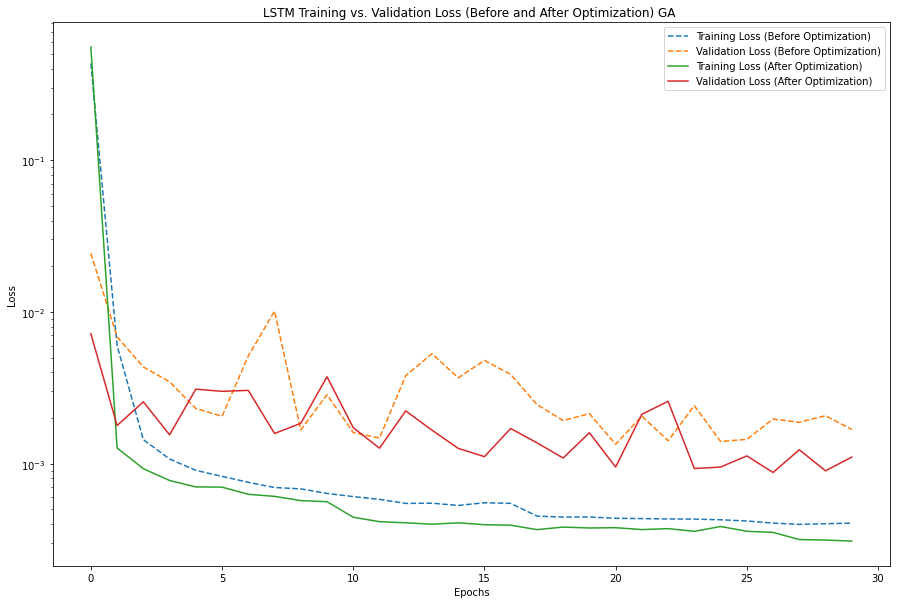

In [46]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(15, 10))

# Plotting loss before optimization
plt.plot(history_lstm_before_optimization.history['loss'], label='Training Loss (Before Optimization)', linestyle='--')
plt.plot(history_lstm_before_optimization.history['val_loss'], label='Validation Loss (Before Optimization)', linestyle='--')

# Plotting loss after optimization
plt.plot(history_lstm_after_optimization_ga3.history['loss'], label='Training Loss (After Optimization)')
plt.plot(history_lstm_after_optimization_ga3.history['val_loss'], label='Validation Loss (After Optimization)')

plt.title('LSTM Training vs. Validation Loss (Before and After Optimization) GA ')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Setting the y-axis to logarithmic scale
plt.yscale('log')

plt.legend()
plt.show()

### GA (6,4,3)



Best Hyperparameters: {'lstm_units': 133, 'batch_size': 55, 'time_steps': 32, 'early_stopping_patience': 9, 'reduce_lr_factor': 0.4802151499738865, 'reduce_lr_patience': 8, 'reduce_lr_min_lr': 1.0913029678196545e-05}
Best Validation Loss: 0.0009087765938602388

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

t_steps = 32
X, y = create_dataset(model_scaled_features, model_scaled_target, t_steps)

train_size = int(0.80 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# converting into tensor
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

input_shape = (X_train.shape[1], X_train.shape[2])

#batch size and no of epochs
num_epochs = 30
batch_size = 55

model_optimized = Sequential([
    # First LSTM layer with regularization
    LSTM(133, return_sequences=True,
            kernel_regularizer=l2(0.01),
            recurrent_regularizer=l2(0.01),
            input_shape=input_shape),
    Dropout(0.2),

    # Second LSTM layer
    LSTM(133, return_sequences=False,
            kernel_regularizer=l2(0.01),
            recurrent_regularizer=l2(0.01)),
    Dropout(0.2),

    # Output layer
    Dense(1)
])

model_optimized.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=9,
    restore_best_weights=True
)

# Reducing learning rate when plateau is reached
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.4802151499738865,
    patience=8,
    min_lr=1.0913029678196545e-05
)

history_lstm_after_optimization_ga4 = model_optimized.fit(
        X_train, y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

2024-12-04 16:25:27.568810: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2027] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 8.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
2024-12-04 16:25:27.576620: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2027] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 8.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
2024-12-04 16:25:28.627191: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22278 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:17:00.0, compute capability: 8.0


Epoch 1/30


2024-12-04 16:25:32.804719: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2024-12-04 16:25:32.929119: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-12-04 16:25:32.929626: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fec5810ead0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-04 16:25:32.929642: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A30, Compute Capability 8.0
2024-12-04 16:25:32.933797: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-04 16:25:33.045041: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


230/230 [==============================] - 6s 8ms/step - loss: 0.5740 - val_loss: 0.0059 - lr: 0.0010
Epoch 2/30
230/230 [==============================] - 1s 5ms/step - loss: 0.0018 - val_loss: 0.0062 - lr: 0.0010
Epoch 3/30
230/230 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 0.0019 - lr: 0.0010
Epoch 4/30
230/230 [==============================] - 1s 4ms/step - loss: 8.4062e-04 - val_loss: 0.0020 - lr: 0.0010
Epoch 5/30
230/230 [==============================] - 1s 4ms/step - loss: 7.2800e-04 - val_loss: 0.0044 - lr: 0.0010
Epoch 6/30
230/230 [==============================] - 1s 4ms/step - loss: 6.8886e-04 - val_loss: 0.0030 - lr: 0.0010
Epoch 7/30
230/230 [==============================] - 1s 4ms/step - loss: 6.0250e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 8/30
230/230 [==============================] - 1s 4ms/step - loss: 5.8033e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 9/30
230/230 [==============================] - 1s 4ms/step - loss: 5.5526e-04 - 

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, rmse, mae

In [13]:
# Making predictions on the test set
# lstm_predictions = model.predict(X_test)
from sklearn.preprocessing import MinMaxScaler


predictions = model_optimized.predict(X_test)

# Adding dummy columns to match the original scaled data shape (5 columns)
# 4 dummy columns to match Open, High, Low, Volume
dummy_columns = np.zeros((predictions.shape[0], 4))
predicted_prices_scaled = np.concatenate((dummy_columns, predictions), axis=1)

# Applying inverse transformation to get back to original scale
predicted_prices = model_feature_scaler.inverse_transform(predicted_prices_scaled)[:, -1]

# for actual prices
actual_prices_scaled = np.concatenate((dummy_columns, y_test.numpy().reshape(-1, 1)), axis=1)
actual_prices = model_feature_scaler.inverse_transform(actual_prices_scaled)[:, -1]

# Calculating metrics
lstm_mse, lstm_rmse, lstm_mae = calculate_metrics(actual_prices, predicted_prices)
print(f'LSTM Model GA(6,4,3) - MSE: {lstm_mse:.4f}, RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}')

99/99 [==============================] - 1s 2ms/step
LSTM Model GA(6,4,3) - MSE: 35.9421, RMSE: 5.9952, MAE: 4.1929


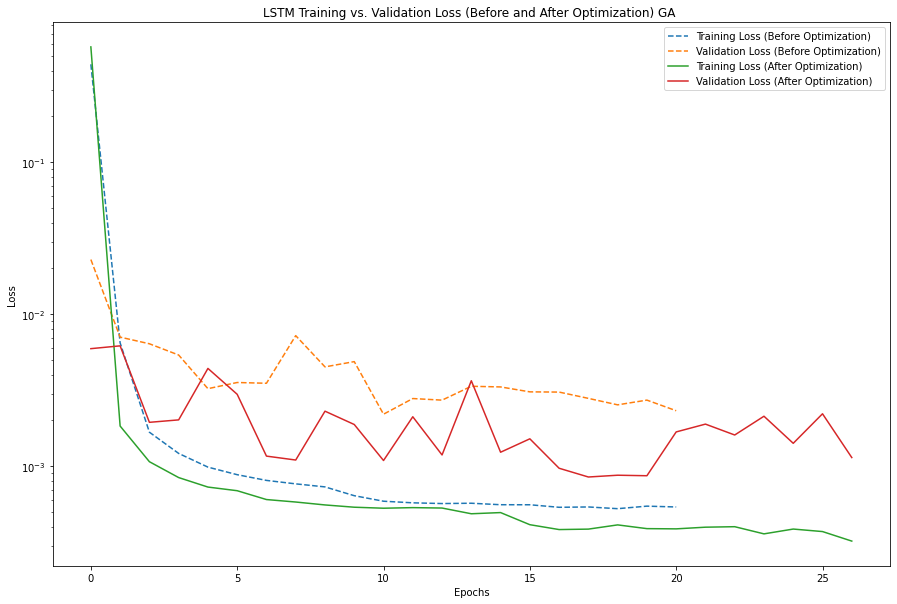

In [39]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(15, 10))

# Plotting loss before optimization
plt.plot(history_lstm_before_optimization.history['loss'], label='Training Loss (Before Optimization)', linestyle='--')
plt.plot(history_lstm_before_optimization.history['val_loss'], label='Validation Loss (Before Optimization)', linestyle='--')

# Plotting loss after optimization
plt.plot(history_lstm_after_optimization_ga4.history['loss'], label='Training Loss (After Optimization)')
plt.plot(history_lstm_after_optimization_ga4.history['val_loss'], label='Validation Loss (After Optimization)')

plt.title('LSTM Training vs. Validation Loss (Before and After Optimization) GA ')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Setting the y-axis to logarithmic scale
plt.yscale('log')

plt.legend()
plt.show()

PSO (6,6)

4,4 
Best Hyperparameters: LSTM Units = 232, Batch Size = 38, Time Steps = 98, Early Stopping Patience = 11, Reduce LR Factor = 0.26, Reduce LR Patience = 5, Min LR = 0.000046


In [38]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

t_steps = 98
X, y = create_dataset(model_scaled_features, model_scaled_target, t_steps)

train_size = int(0.80 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# converting into tensor
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

input_shape = (X_train.shape[1], X_train.shape[2])

#batch size and no of epochs
num_epochs = 30
batch_size = 38

model_optimized = Sequential([
    # First LSTM layer with regularization
    LSTM(232, return_sequences=True,
            kernel_regularizer=l2(0.01),
            recurrent_regularizer=l2(0.01),
            input_shape=input_shape),
    Dropout(0.2),

    # Second LSTM layer
    LSTM(232, return_sequences=False,
            kernel_regularizer=l2(0.01),
            recurrent_regularizer=l2(0.01)),
    Dropout(0.2),

    # Output layer
    Dense(1)
])

model_optimized.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=11,
    restore_best_weights=True
)

# Reducing learning rate when plateau is reached
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.26,
    patience=5,
    min_lr=0.000046
)

history_lstm_after_optimization_pso44 = model_optimized.fit(
        X_train, y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

Epoch 1/30
332/332 [==============================] - 6s 10ms/step - loss: 0.5159 - val_loss: 0.0027 - lr: 0.0010
Epoch 2/30
332/332 [==============================] - 3s 8ms/step - loss: 0.0012 - val_loss: 0.0037 - lr: 0.0010
Epoch 3/30
332/332 [==============================] - 3s 8ms/step - loss: 9.0544e-04 - val_loss: 0.0013 - lr: 0.0010
Epoch 4/30
332/332 [==============================] - 3s 8ms/step - loss: 7.7596e-04 - val_loss: 0.0168 - lr: 0.0010
Epoch 5/30
332/332 [==============================] - 3s 8ms/step - loss: 7.9389e-04 - val_loss: 0.0043 - lr: 0.0010
Epoch 6/30
332/332 [==============================] - 3s 8ms/step - loss: 6.7037e-04 - val_loss: 0.0018 - lr: 0.0010
Epoch 7/30
332/332 [==============================] - 3s 8ms/step - loss: 6.1633e-04 - val_loss: 0.0023 - lr: 0.0010
Epoch 8/30
332/332 [==============================] - 3s 8ms/step - loss: 6.0486e-04 - val_loss: 0.0019 - lr: 0.0010
Epoch 9/30
332/332 [==============================] - 3s 8ms/step - los

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, rmse, mae

In [40]:
# Making predictions on the test set
# lstm_predictions = model.predict(X_test)
from sklearn.preprocessing import MinMaxScaler


predictions = model_optimized.predict(X_test)

# Adding dummy columns to match the original scaled data shape (5 columns)
# 4 dummy columns to match Open, High, Low, Volume
dummy_columns = np.zeros((predictions.shape[0], 4))
predicted_prices_scaled = np.concatenate((dummy_columns, predictions), axis=1)

# Applying inverse transformation to get back to original scale
predicted_prices = model_feature_scaler.inverse_transform(predicted_prices_scaled)[:, -1]

# for actual prices
actual_prices_scaled = np.concatenate((dummy_columns, y_test.numpy().reshape(-1, 1)), axis=1)
actual_prices = model_feature_scaler.inverse_transform(actual_prices_scaled)[:, -1]

# Calculating metrics
lstm_mse, lstm_rmse, lstm_mae = calculate_metrics(actual_prices, predicted_prices)
print(f'LSTM Model PSO(44) - MSE: {lstm_mse:.4f}, RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}')

99/99 [==============================] - 1s 4ms/step
LSTM Model PSO(44) - MSE: 45.5410, RMSE: 6.7484, MAE: 4.5604


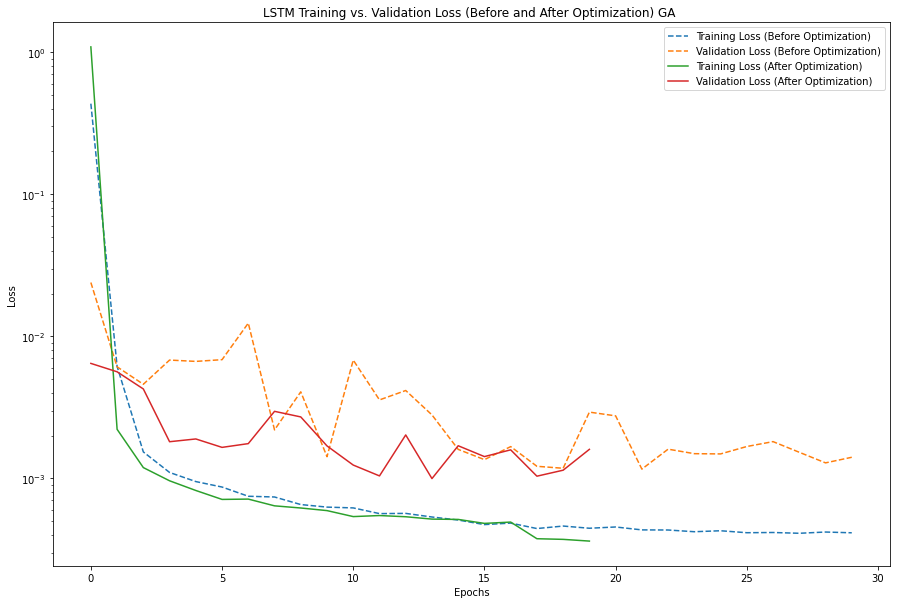

In [37]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(15, 10))

# Plotting loss before optimization
plt.plot(history_lstm_before_optimization.history['loss'], label='Training Loss (Before Optimization)', linestyle='--')
plt.plot(history_lstm_before_optimization.history['val_loss'], label='Validation Loss (Before Optimization)', linestyle='--')

# Plotting loss after optimization
plt.plot(history_lstm_after_optimization_pso44.history['loss'], label='Training Loss (After Optimization)')
plt.plot(history_lstm_after_optimization_pso44.history['val_loss'], label='Validation Loss (After Optimization)')

plt.title('LSTM Training vs. Validation Loss (Before and After Optimization) GA ')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Setting the y-axis to logarithmic scale
plt.yscale('log')

plt.legend()
plt.show()